# Visualizing IPC Code Evolution

Copyright 2020, Sanjay Dasgupta

This notebook illustrates a technique for visualizing the spread of [International Patent Classification](https://www.wipo.int/classifications/ipc/en/) codes (_IPC_ henceforth) in sets of patent documents. Such visualizations enable the comparison of different sets of patent documents (say from different companies), or even the evolution of the same set over time. 

IPC codes use a hierarchic classification, and the technique used here can be used to analyze any data that uses a hierarchic classification strategy.

## 1. The Structure and Nature of IPC Codes
IPC codes contain 5 parts (_section_, _class_, _subclass_, _group_, and _subgroup_) that constitute a 5-level hierarchy. The details are described under _What is the IPC?_ in the [IPC FAQ](https://www.wipo.int/classifications/ipc/en/faq). Over 70,000 distinct IPC codes are defined by [WIPO](https://www.wipo.int/about-wipo/en/) the organization that maintains the IPC specification.

The structure of IPC codes define a hierarchic classification, so every pair of distinct IPC codes is not necessarily completely unrelated. Any pair of IPC codes has a certain degree of _similarity_ (or dissimilarity). A pair is completely unrelated if the first part (_section_) is not the same. But their degree of similarity increases as the number of matching parts at the beginning (or higher levels) of the code increases. Thus, `G07C3/00` and `C22B1/16` are completely unrelated, but `C22B34/32` and `C22C38/06` are related by belonging to the same section (`C`) and class (`22`). 

This is a somewhat naive interpretation of the similarity of distinct IPC codes, but is adequate for the purposes of this effort. To understand why this measure of similarity may be inadequate for certain other needs, examine the patent application [Integrated insulin delivery system with continuous glucose sensor](https://patents.google.com/patent/EP2227132A4/en). Note that it is classified under both `A61M5/1723` and `G06F19/3468` (completely unrelated by the above logic). 

### 1.1 Using Scatter Plots to Depict Clustering of IPC Codes 

In the following sections of this notebook, we transform IPC codes into a textual representation that enables the application of standard [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning) tools and techniques to produce a [Scatter Plot](https://en.wikipedia.org/wiki/Scatter_plot) that depicts the [clustering](https://en.wikipedia.org/wiki/Cluster_analysis) of IPC codes in a set of patent documents. The transformation of features into a different, more effective form, is often called [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering).


### 1.2 Source of the Data Used
The dataset used by this notebook has been extracted from successive weekly editions of _Official Journal of the Patent Office_ [published by the Indian Patent Office](http://www.ipindia.nic.in/journal-patents.htm) from the beginning of 2008 to the end of 2019 (about 10 years). Those records have been filtered to retain applications filed by a well known steel manufacturing company.

## 2. How to Run this Notebook

This notebook is [stored in GitBub](https://github.com/sanjaydasgupta/ipc-code-evolution/blob/master/ipc-evolution-steel-company.ipynb), and you can run it in Google colaboratory by clicking this link: 
<a href="https://colab.research.google.com/github/sanjaydasgupta/ipc-code-evolution/blob/master/ipc-evolution-steel-company.ipynb">Run in Google Colaboratory</a>

The dataset used is also [stored on GitHub](https://github.com/sanjaydasgupta/ipc-code-evolution/blob/master/steel-ipc-dates.csv), and is accessed directly (over HTTP) without the need to download it to the host machine.

<h2>1. Imports and other Preliminary Actions</h2>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<h2>2. Load Data into Pandas DataFrame</h2>

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sanjaydasgupta/ipc-code-evolution/master/steel-ipc-dates.csv')

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

Data has 870 rows and 4 columns
Column names: applicationNumber, filingDate, publicationDate, ipc


In [3]:
print(df['publicationDate'].min(), df['publicationDate'].max())
df.sample(10)

2008-02-22 2019-12-27


,applicationNumber,filingDate,publicationDate,ipc
298,306/KOL/2009 A,2009-02-18,2010-08-27,C23F 11/00
326,802/KOL/2007 A,2007-05-24,2009-04-03,C22B 34/00
87,201631010477 A,2016-03-28,2017-11-10,C21B 11/10
380,201631040570 A,2016-11-28,2018-06-01,"C21C 5/00, F22B 1/00, F27D 3/00"
305,691/KOL/2011 A,2011-05-19,2012-11-23,F16G 1
318,599/KOL/2012 A,2012-05-25,2013-11-29,D21C
9,386/KOL/2006 A,2006-04-28,2009-04-03,G06F 19/00
604,268/KOL/2012 A,2012-03-12,2013-09-13,"B32B 0, B32B 15/00"
840,201731008485 A,2017-03-10,2018-09-14,"C23C 14/00, G01N 21/71, G01N 21/73"
128,622/KOL/2008 A,2008-03-28,2009-10-02,C22C 38/20


<h2>3. Data Cleaning and Enrichment</h2>

This is also called  [wrangling](https://en.wikipedia.org/wiki/Data_wrangling)

<h3>3.1 Break Down Composite IPC Values</h3>

The following code splits CSVs containing multiple IPCs, validates the individual IPCs, and then explodes each into the constituent parts (_section_, _class_, _subclass_, _group_, and _subgroup_).

In [4]:
ipc_regex_pattern = r'\s*'.join([
  '([A-H])', 
  '([0-9]{2})',
  '([A-Z])',
  r'(?:([0-9]{1,5})(?:\s*/?\s*([0-9]{1,5}))?)?'
])

#print(ipc_regex_pattern)
ipc_regex = re.compile(ipc_regex_pattern)

def ipc_explode(ipc):
  m = re.fullmatch(ipc_regex, ipc)
  if m:
    ipc_parts = [e for e in m.groups() if e]
    return ipc_parts[:3] + ['%05d' % int(e) for e in ipc_parts[3:]]
  else:
    return None

def ipc_csv_to_exploded_array(ipc_csv):
  ipc_array = [ipc.strip() for ipc in ipc_csv.split(',')]
  exploded_ipcs = [ipc_explode(ipc) for ipc in ipc_array]
  clean_exploded_ipcs = [e for e in exploded_ipcs if e]
  return clean_exploded_ipcs

df['ipcs_exploded'] = df['ipc'].fillna('').map(ipc_csv_to_exploded_array)

for ipcs in df['ipcs_exploded'].sample(10):
  print(ipcs)

[['C', '21', 'D', '00001', '00000']]
[['C', '22', 'B', '00001', '00000']]
[['B', '22', 'D', '00011', '00005']]
[['C', '21', 'C', '00005', '00032']]
[['C', '21', 'D', '00009', '00046']]
[['E', '21', 'B', '00001', '00026']]
[['C', '04', 'B', '00005', '00000'], ['C', '21', 'C', '00005', '00036'], ['F', '27', 'D', '00015', '00000']]
[['B', '28', 'B', '00011', '00024']]
[['C', '10', 'B', '00053', '00008']]
[['C', '21', 'C', '00007', '00000'], ['C', '21', 'D', '00008', '00012']]


<h3>3.2 Remove Rows with Invalid IPC Data</h3>

In [5]:
df2 = df[df['ipcs_exploded'].map(lambda s: len(s) > 0)].copy()

print(df2.shape)

(867, 5)


<h2>5. Convert IPC codes into Text (<i>Sentences</i>)</h2>

Convert the IPC codes into sentences-like values to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

In [6]:
def ipc2sentence(ipc):
    s = ipc[0] if ipc else ''
    if ipc and len(ipc) > 1:
        s += ' ' + ipc[0] + ipc[1]
        if len(ipc) > 2:
            s += ' ' + ipc[0] + ipc[1] + ipc[2]
            if len(ipc) > 3:
                s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3]
                if len(ipc) > 4:
                    s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3] + ipc[4]
    return s

def exploded_ipc_array_to_sentence(ipcs):
    return ' '.join([ipc2sentence(ipc) for ipc in ipcs])

df2['ipcs_sentence'] = df2['ipcs_exploded'].map(exploded_ipc_array_to_sentence)

for ipc_sentence in df2['ipcs_sentence'].sample(10):
    print(ipc_sentence)

C C21 C21B C21B00013 C21B0001300000
G G01 G01N G01N00033 G01N0003300053 G G01 G01N G01N00001 G01N0000100028 G G01 G01N G01N00033 G01N0003300543
C C21 C21C C21C00007 C21C0000700000
B B66 B66C B66C00001 B66C0000100054
C C21 C21D C21D00008 C21D0000800000
C C21 C21D C21D00006 C21D0000600000
G G02 G02B G02B00026 G02B0002600000
C C03 C03C C03C00017 C03C0001700036
C C23 C23C C23C00002 C23C0000200000
C C10 C10L C10L00005 C10L0000500000


<h3>5.3 Generate Feature (Word) Count Vectors</h3>

This part uses the well-known [scikit-learn](https://scikit-learn.org/) facilities for text processing.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', tokenizer=str.split, stop_words=[]).fit(df2['ipcs_sentence'])
ipc_vectors = vectorizer.transform(df2['ipcs_sentence'])
print('Rows: %d, Features: %d' % ipc_vectors.shape)
print('Stop words: %s' % vectorizer.stop_words_)

Rows: 867, Features: 1326
Stop words: set()


/home/yajnas/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<h2>6. Prepare Word-Counts for Scatter Plot Display</h2>

To facilitate depiction as a scatter plot, the feature vectors are reduced to 2 dimensions by using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE).

<h3>6.1 Use <monospace>TruncatedSVD</monospace> to Reduce the Number of Features</h3>

In [8]:
# Not required, as the number of features is not that large

#from sklearn.decomposition import TruncatedSVD

#tsvd = TruncatedSVD(n_components=150, random_state=42)
#tsvd100 = tsvd.fit_transform(tf)
#print('Rows: %d, Features: %d' % tsvd100.shape)

<h3>6.2 Use <i>t-SNE</i> to Obtain 2-D (X, Y) Mapping</h3>

In [9]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

tsne = TSNE(n_components=2, n_jobs=-1, random_state=24).fit_transform(ipc_vectors)
print('Rows: %d, Features: %d' % tsne.shape)

tsne_scaled = MinMaxScaler().fit_transform(tsne)

df2['tsne_x'] = tsne_scaled[:, 0]
df2['tsne_y'] = tsne_scaled[:, 1]

display(df2.sample(5))

Rows: 867, Features: 2


,applicationNumber,filingDate,publicationDate,ipc,ipcs_exploded,ipcs_sentence,tsne_x,tsne_y
810,201631004862 A,2016-02-11,2017-11-10,E04C 5/16,"[[E, 04, C, 00005, 00016]]",E E04 E04C E04C00005 E04C0000500016,0.518501,0.383774
200,888/CHENP/2014 A,2014-02-04,2016-07-01,"C23C 2/26, C09D 5/08","[[C, 23, C, 00002, 00026], [C, 09, D, 00005, 0...",C C23 C23C C23C00002 C23C0000200026 C C09 C09D...,0.545036,0.701999
698,368/KOL/2007 A,2007-03-13,2008-10-03,G01B 5/08,"[[G, 01, B, 00005, 00008]]",G G01 G01B G01B00005 G01B0000500008,0.083029,0.503611
666,306/KOL/2015 A,2015-03-23,2017-10-13,B21B 37/00,"[[B, 21, B, 00037, 00000]]",B B21 B21B B21B00037 B21B0003700000,0.693796,0.038914
74,647/KOL/2009 A,2009-04-21,2016-09-02,C21B,"[[C, 21, B]]",C C21 C21B,0.812893,0.648271


<h2>7. Scatter-Plots of IPC Codes</h2>

Create utility dictionaries to define the colors used for each section, and the description of each section.

In [10]:
cmap = {'A': 'coral', 'B': 'green', 'C': 'slateblue', 'D': 'cyan', 'E': 'magenta', 'F': 'maroon', 
    'G': 'orange', 'H': 'blue'}

ipc_section_text = {
  'A': 'Human Necessities', 
  'B': 'Performing Ops; Transporting', 
  'C': 'Chemistry; Metallurgy', 
  'D': 'Textiles; Paper', 
  'E': 'Fixed Constructions', 
  'F': 'Mech Engg; Lighting; Heating ...', 
  'G': 'Physics', 
  'H': 'Electricity'
}

<h3>7.1 Clusters in Entire Data Set</h3>

The following cells produce two scatter plots. Figure-1 below (on the left) shows how different IPC code values are scattered around in the plot. The second plot (on the right) gives each point a color based on the _section_ part of its IPC code. Notice how the points are grouped together into clusters by _section_ value.

In [11]:
from collections import Counter

def decorate(ax, cmap, sizemm, fontsize=14):
  if cmap:
    sections = sorted(list(cmap.keys()))
    #legend_data = [[2 / sizemm, 4 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
    #    i, section in enumerate(sections)]
    legend_data = [[0, 2 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
        i, section in enumerate(sections)]
    legends = pd.DataFrame(legend_data, columns=['x1', 'x2', 'y', 'section', 'color'])
    legends.plot.scatter(ax=ax, x='x1', y='y', color=legends['color'].values, marker='s', s=72, grid=True)
    for legend in legends.values:
      section_text = '%s (%s)' % (legend[3], ipc_section_text[legend[3]])
      ax.text(legend[1], legend[2] - 1 / sizemm, section_text, fontsize=fontsize)

  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_xticklabels(['' for i in range(6)])
  ax.set_yticklabels(['' for i in range(7)])

def ipc_color(df):
  #sections = df['ipcs_sentence'].map(lambda sentence: [word for word in sentence.split() if len(word) == 1])
  sections = df['ipcs_sentence'].map(lambda sentence: [word[0] for word in sentence.split()])
  most_common_section = sections.map(lambda a: Counter(a).most_common(1)[0][0])
  section_colors = most_common_section.map(cmap)
  #section_colors = sections.map(lambda ss: cmap[ss[0]])
  return section_colors.values

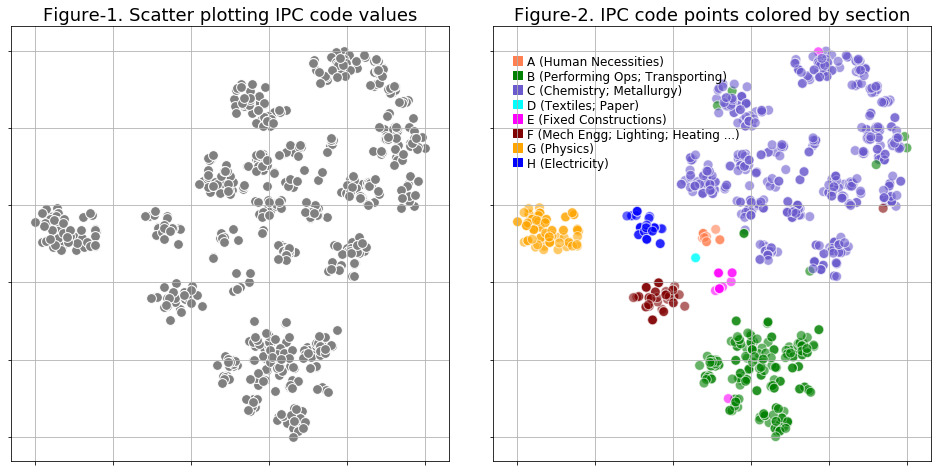

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))

df2.plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', color='gray', edgecolors='white', s=96, grid=True)
axes[0].set_title('Figure-1. Scatter plotting IPC code values', fontsize=18)
decorate(axes[0], None, None)

#colors = [cmap[section] if section in cmap else 'red' for section in df2['ipcs_sentence'].str[0]]
colors = ipc_color(df2)
df2.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, edgecolors='white', s=96)
axes[1].set_title('Figure-2. IPC code points colored by section', fontsize=18)
decorate(axes[1], cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1)
fig.savefig('figure-1-2')

None

<h3>7.2 Drilling down into the Clusters (Hierarchic Classification)</h3>

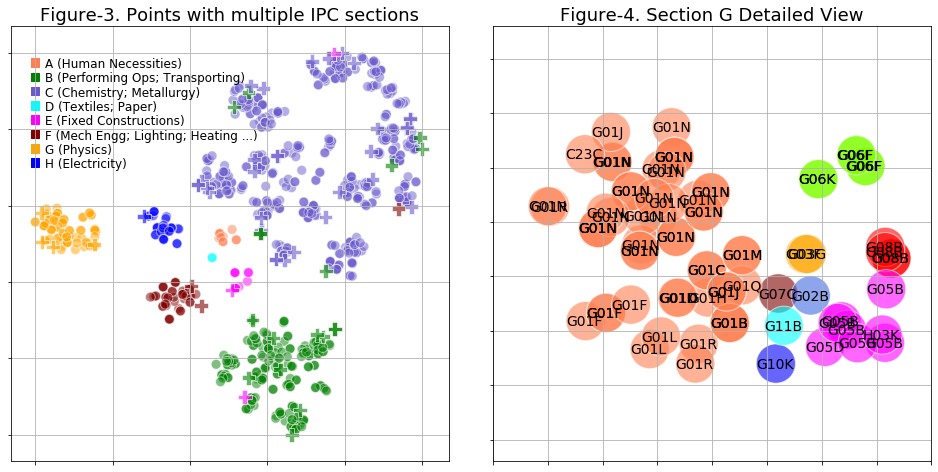

In [14]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16.5, 8))
#
#    First graph
#
one_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 1 for ipc3 in df2['ipcs_sentence']]
two_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 2 for ipc3 in df2['ipcs_sentence']]
more_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) > 2 for ipc3 in df2['ipcs_sentence']]

#colors = [cmap[section] if section in cmap else 'red' for section in df2[one_ipc]['ipc'].str[0]]
colors = ipc_color(df2[one_ipc])
df2[one_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', 
    alpha=0.5, color=colors, edgecolors='white', s=96, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[two_ipc]['ipc'].str[0]]
colors = ipc_color(df2[two_ipc])
df2[two_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='P', s=192, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[more_ipc]['ipc'].str[0]]
colors = ipc_color(df2[more_ipc])
df2[more_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='X', s=192, grid=True)

decorate(axes[0], cmap, 80, fontsize=12)
axes[0].set_title('Figure-3. Points with multiple IPC sections', fontsize=18)
#
#    Second graph
#
dfg = df2.query("tsne_x < 0.2")
axes[1].set_ylim(0.44, 0.64)
axes[1].set_xlim(-0.025, 0.175)
colors = {'G01': 'coral', 'G02': 'royalblue', 'G03': 'orange', 'G04': 'cyan', 'G05': 'magenta', 'G06': 'chartreuse', 
    'G07': 'maroon', 'G08': 'red', 'G10': 'blue', 'G11': 'cyan'}
classes = dfg['ipcs_sentence'].map(lambda sentence: [word[:3] for word in sentence.split() if len(word) >= 3])
most_common_class = classes.map(lambda a: Counter(a).most_common(1)[0][0])
color = [colors[cls] if cls in colors else 'white' for cls in most_common_class]
dfg.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=color, 
    edgecolors='white', s=1536, grid=True)
for row in dfg[['tsne_x', 'tsne_y', 'ipc']].values:
  x, y, ipc = row[0], row[1], row[2]
  colors = {'01': 'red', '02': 'maroon', '03': 'blue', '04': 'cyan', '05': 'magenta', '06': 'green'}
  color = colors[ipc[1:3]] if ipc[1:3] in colors else 'black'
  axes[1].text(x - 0.009, y - 0.002, ipc[0:4], color='black', fontsize=14)
decorate(axes[1], None, None)
axes[1].set_title('Figure-4. Section G Detailed View', fontsize=18)

fig.subplots_adjust(wspace=0.1)
fig.savefig('figure-3-4')

None

<h2>8. The evolution of IPC Codes</h2>

In [17]:
import matplotlib.pyplot as plt

def twin_charts(year, fignum):
  fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))
  axes = axes.ravel()

  for ax, base_year in zip(axes, [year, year + 2]):

    futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
    futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

    pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
    pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

    currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
    colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
    colors = ipc_color(currentdf)
    currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

    ax.set_title('Figure-%d. Years %d and %d' % (fignum, base_year, base_year + 1), fontsize=14)
    fignum += 1
  
    decorate(ax, cmap, 80, fontsize=12)

  fig.subplots_adjust(wspace=0.1, hspace=0.1)
  fig.savefig('figure-%d-%d' % (fignum - 2, fignum -1))

<h3>8.1 From 2008 to 2011</h3>

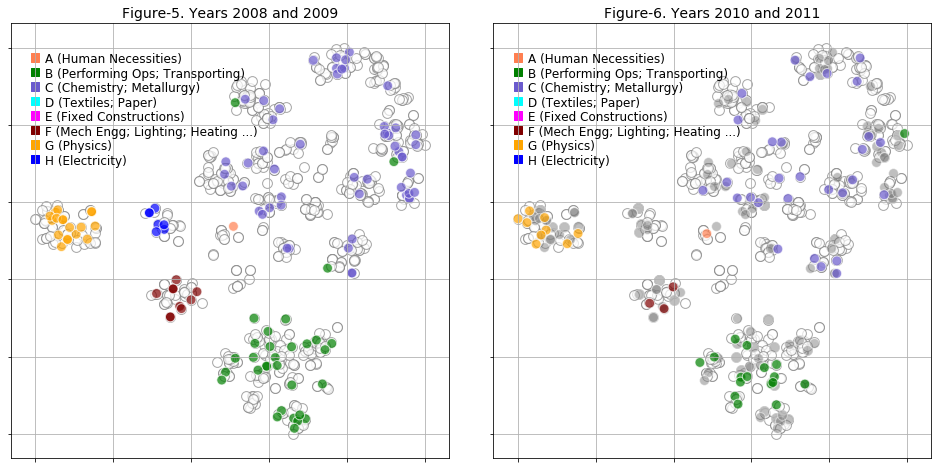

In [18]:
twin_charts(2008, 5)

<h3>8.2 From 2012 to 2015</h3>

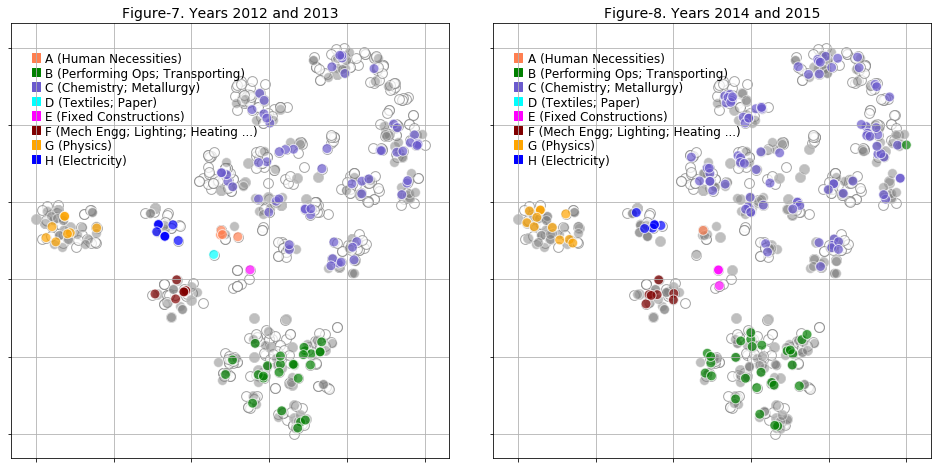

In [19]:
twin_charts(2012, 7)

<h3>8.1 From 2016 to 2019</h3>

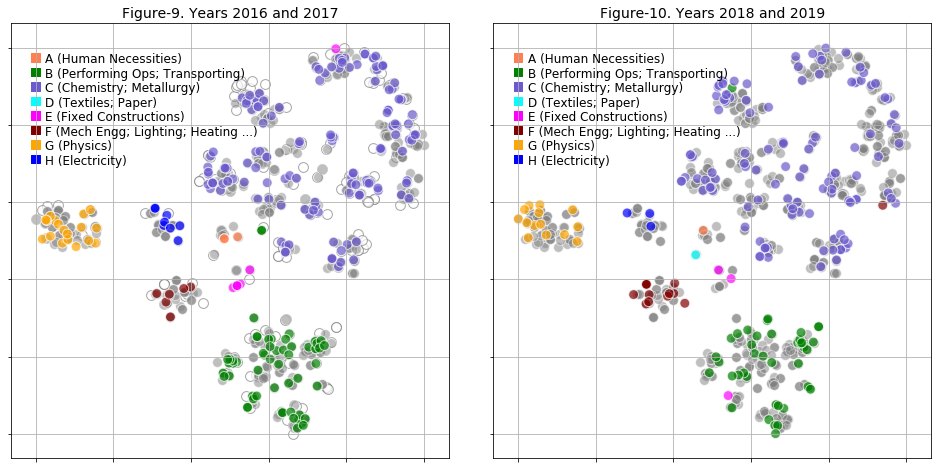

In [20]:
twin_charts(2016, 9)

<h2>9. All 6 Charts Together</h2>

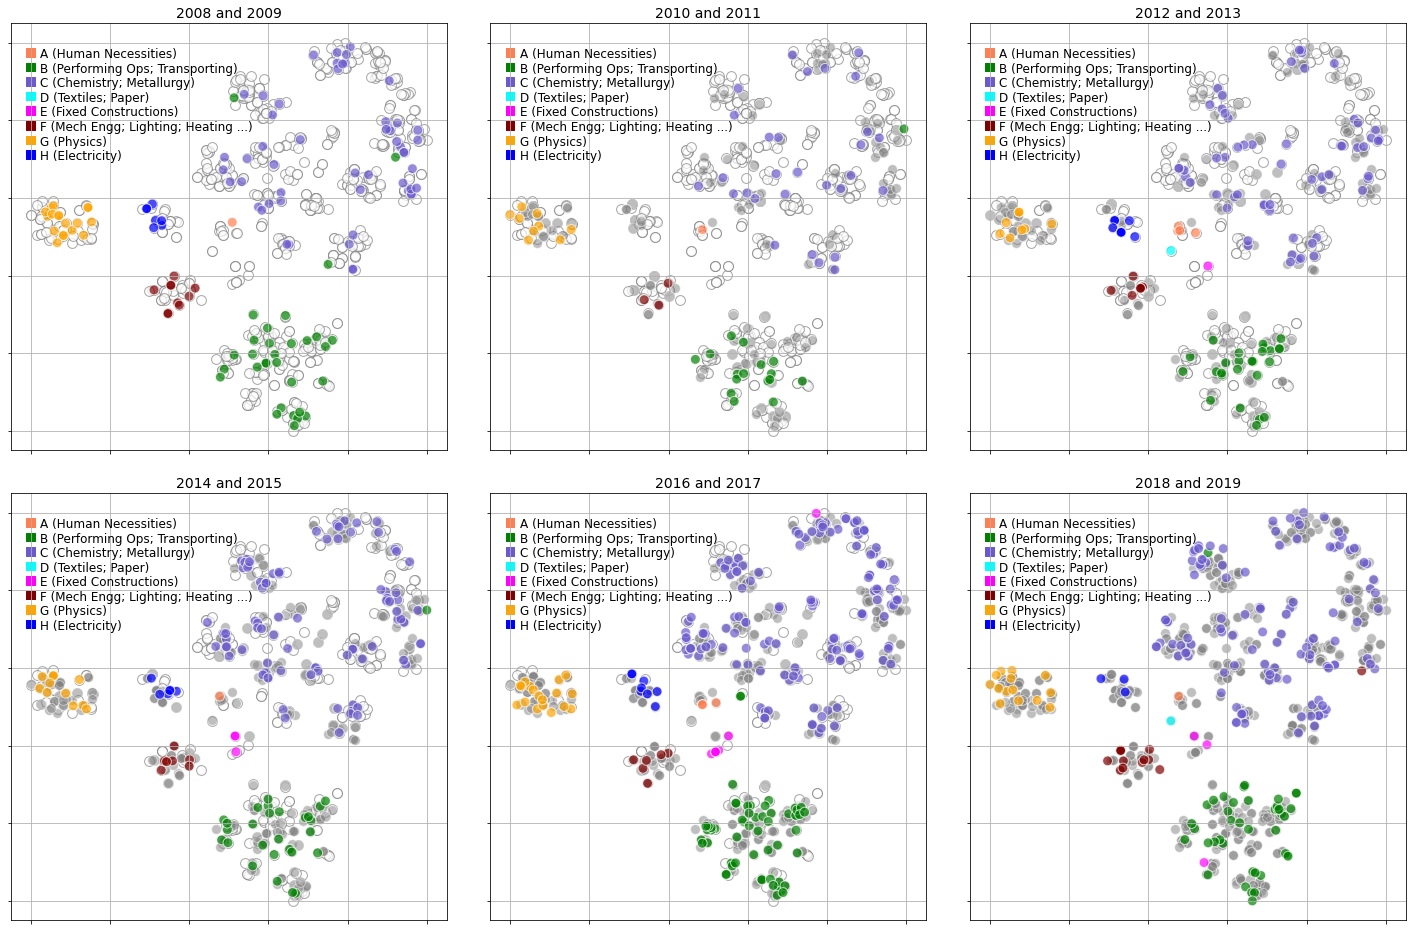

In [ ]:
import matplotlib.pyplot as plt

fig, axes23 = plt.subplots(2, 3, sharey=True, figsize=(25, 16.5))
axes = axes23.ravel()

for ax, base_year in zip(axes, range(2008, 2019, 2)):

  futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
  futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

  pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
  pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

  currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
  colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
  colors = ipc_color(currentdf)
  currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

  ax.set_title('%d and %d' % (base_year, base_year + 1), fontsize=14)
  
  decorate(ax, cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

None